In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import Bounds

In [6]:
from utils.constants import clusters
from liquid_models.crmp import CRMP

In [22]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, c_out) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

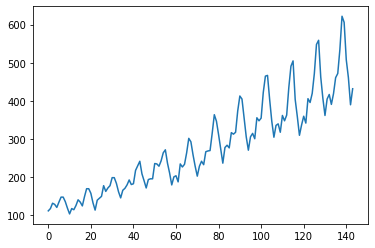

In [17]:
training_set = pd.read_csv('airline-passengers.csv')
#training_set = pd.read_csv('shampoo.csv')

training_set = training_set.iloc[:,1:2].values

#plt.plot(training_set, label = 'Shampoo Sales Data')
plt.plot(training_set, label = 'Airline Passangers Data')
plt.show()

## Данные

In [3]:
production = pd.read_excel('2021.06.18_dataset_База_данных(01.01.2017-01.04.2021).xlsx', sheet_name = 'База добычи')
GTM = pd.read_excel('2021.06.18_dataset_База_данных(01.01.2017-01.04.2021).xlsx', sheet_name = 'ГТМ')
injection = pd.read_excel("2021.06.18_dataset_База_данных(01.01.2017-01.04.2021).xlsx", sheet_name='База закачки')

In [11]:
def crmp_plot_and_save(real, pred, well_name, cluster, test_size):
    fig = plt.figure(figsize=(10,5))
    plt.plot([x for x in range(real.shape[0])], real, label='real_values')
    plt.plot([x for x in range(pred.shape[0])], pred, label='predictions CRMP')

    plt.grid()
    plt.title(f"Values for well {well_name} in {cluster}")
    plt.legend(fontsize='xx-large')

    #plt.show()
    #fig.savefig(f'results/Liq - {well_name} in {cluster}.jpg')
    #print(f'Result for {well_name} saved!')

def train_test_split_data(lib_data, data_slice, test_size):
    train = {}
    test = {}
    all_data = {}
    for key, elem in lib_data.items():
        train[key] = elem[:-test_size][-data_slice:]
        test[key] = elem[-test_size:]
        all_data[key] = elem[- (test_size + data_slice):]
    return train, test, all_data


----------------------------------------------------------------------
cluster1
----------------------------------------------------------------------
Результаты для скважины -  AKSH_223
(100,)
(30,)
Start the minimize function....Please wait
Total time =  0.8858063220977783
{'Vp': 0.5, 'PI': 0.1, 'Coef_1': 0.9700981096708395, 'Coef_2': 0, 'Tau': 1325218933.3333335}
(130,)
(130,)
----------------------------------------------------------------------


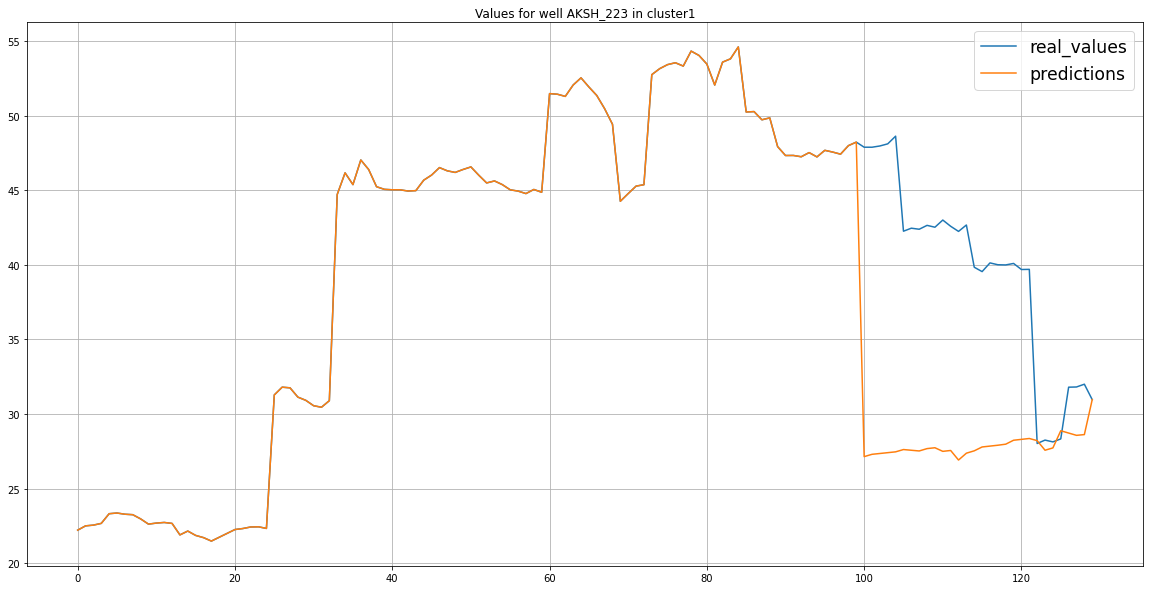

In [10]:
for cluster in clusters:
    print('-'*70)
    print(cluster)
    print('-'*70)
    injwell = clusters[cluster]['injwell']
    for well_name in clusters[cluster]['names_wells']:
        print('Результаты для скважины - ', well_name)
        well_df = production[production['wellname'] == well_name].reset_index(drop=True).copy()

        mask_date = well_df['start_datetime'].duplicated()
        

        well_df = well_df[mask_date == False]

        a = well_df[['start_datetime', 'liq_vol, m3']]
        b = injection[['start_datetime', 'water_inj_vol']][injection['wellname'] == injwell]
        b['start_datetime'] = pd.to_datetime(injection['start_datetime'][injection['wellname'] == injwell])
        c = pd.merge(a,b, on='start_datetime', how='left').fillna(0)
        Inj_well = c['water_inj_vol'].values


        #подготавливаем все данные для данной скважины
        #ВАЖНО: класс CRMP ничего не знает о данных, поэтому важно осуществить проверку на совпадение по размерам и наличию NaNs
        #mask = well_df['liq_vol, m3'].values > 0
        
        # date_full = set(well_df['start_datetime'].values)
        
        # q0_well = well_df['liq_vol, m3'][mask_date == False][pd.to_datetime(well_df['start_datetime']).isin(list(date_full))].values
        # Pwf_well = well_df['bhp_final, bar (fact)'][mask_date == False][pd.to_datetime(well_df['start_datetime']).isin(list(date_full))].values
        # date_well = well_df['start_datetime'][mask_date == False][pd.to_datetime(well_df['start_datetime']).isin(list(date_full))].values
        # Inj_well = Inj['water_inj_vol'][pd.to_datetime(Inj['start_datetime']).isin(list(date_full))].values
        # qoil_well = well_df['oil_vol, m3'][mask_date == False][pd.to_datetime(well_df['start_datetime']).isin(list(date_full))].values
        q0_well = well_df['liq_vol, m3'].values
        Pwf_well = well_df['bhp_final, bar (fact)'].values
        date_well = well_df['start_datetime'].values
        qoil_well = well_df['oil_vol, m3'].values


        # print(len(date_full))
        # print(Pwf_well.shape)
        # print(q0_well.shape)
        # print(date_well.shape)
        # print(Inj_well.shape)
        # print(qoil_well.shape)
        
        mask = q0_well > 0
        q0_well = q0_well[mask]
        Pwf_well = Pwf_well[mask]
        date_well = date_well[mask]
        Inj_well = Inj_well[mask]
        qoil_well = qoil_well[mask]
        
        #проверка на равенство всех размеров
        assert Inj_well.shape == Pwf_well.shape
        assert Inj_well.shape == q0_well.shape
        assert q0_well.shape == date_well.shape
        assert qoil_well.shape == date_well.shape

        #устанавливаем, сколько данных берем с конца
        #можно сделать в процентах
        test_size = 30
        data_slice = 100

        if qoil_well.shape[0] < data_slice:
            print("Error! Small shape of data!")
            print('-'*70)
            continue

        train, test, all_data = train_test_split_data({'pwf': Pwf_well, 
                                            'q0': q0_well, 
                                            'date': date_well, 
                                            'inj': Inj_well, 
                                            'oil': qoil_well}, 
                                            data_slice=data_slice, 
                                            test_size=test_size)
        

        print(train['pwf'].shape)
        print(test['pwf'].shape)

        #создаем CRMP с базовыми параметрами
        train_model = CRMP(Vp=800000, 
                    PI=0.3, 
                    Coef_1=0.5, 
                    Date=train['date'], 
                    Inj=train['inj'], 
                    q0=train['q0'], 
                    Pwf=train['pwf'], 
                    two_inj=False)
        bounds = Bounds([0.5, 0.1, 0.01], [25, 7, 1.0])
        x0 = np.array([0.1, 0.5, 0.2])

        #запускаем поиск оптимальных параметров и предсказываем жидкость
        liq_prediction_for_train = train_model.minimize_and_predict(bounds, x0)

        parameters = train_model.parameters
        print(train_model.parameters)


        final_model = CRMP(Vp=parameters['Vp'], 
                    PI=parameters['PI'], 
                    Coef_1=parameters['Coef_1'], 
                    Date=all_data['date'], 
                    Inj=all_data['inj'], 
                    q0=all_data['q0'], 
                    Pwf=all_data['pwf'], 
                    two_inj=False)

        liq_prediction_final = np.array(list(all_data['q0'][:-test_size]) + list(final_model.predict().reshape((-1,))[-test_size:]))

        print(liq_prediction_final.shape)
        print(all_data['q0'].shape)
    
        #отрисовываем график жидкости и сохраняем
        crmp_plot_and_save(all_data['q0'], liq_prediction_final, well_name, cluster, test_size)
        print('-'*70)
        break
    break

In [15]:
data = all_data['q0'].reshape((all_data['q0'].shape[0], 1))

In [40]:
training_set = data

In [46]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 90
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

## Training

In [47]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm.forward(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.06771
Epoch: 100, loss: 0.00716
Epoch: 200, loss: 0.00603
Epoch: 300, loss: 0.00197
Epoch: 400, loss: 0.00183
Epoch: 500, loss: 0.00175
Epoch: 600, loss: 0.00170
Epoch: 700, loss: 0.00168
Epoch: 800, loss: 0.00162
Epoch: 900, loss: 0.00163
Epoch: 1000, loss: 0.00158
Epoch: 1100, loss: 0.00160
Epoch: 1200, loss: 0.00153
Epoch: 1300, loss: 0.00165
Epoch: 1400, loss: 0.00150
Epoch: 1500, loss: 0.00145
Epoch: 1600, loss: 0.00147
Epoch: 1700, loss: 0.00142
Epoch: 1800, loss: 0.00142
Epoch: 1900, loss: 0.00137


In [ ]:
lstm.parameters()

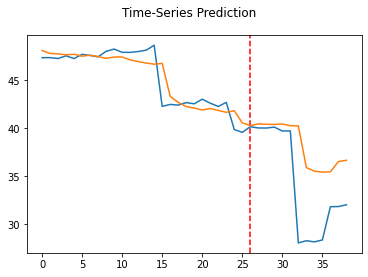

In [48]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [45]:
130 * 0.67

87.10000000000001

In [39]:
lstm.lstm.forward(dataX[0].reshape(1,4,1))

(tensor([[[0.2756, 0.0852],
          [0.4273, 0.1758],
          [0.5162, 0.2552],
          [0.5646, 0.3215]]], grad_fn=<TransposeBackward0>),
 (tensor([[[0.5646, 0.3215]]], grad_fn=<StackBackward>),
  tensor([[[0.7659, 0.4264]]], grad_fn=<StackBackward>)))

In [38]:
dataX[0].reshape(1,4,1)

tensor([[[0.0221],
         [0.0308],
         [0.0323],
         [0.0358]]])